<img src="https://www.tunelf.com/wp-content/uploads/2020/07/spotify-lyrics.jpg" width="400" height = "50" >


  ### Group Project  - Using Spotify Song Lyrics to predict success
  ### By Arunkkumar Karthikeyan, Diaz Gonzalez Manjarrez Fernando, Lucero Fernandez Fabrizio, Maria Karakoulian

### Information on the work :

The goal of this project is to use Natural Language Processing (NLP) techniques to predict the success of a song based on its lyrics. The dataset used for this project contains information on the music, such as danceability, energy, and tempo, as well as the lyrics scraped from Genius.

To begin, the dataset will be loaded into Python and pre-processed to prepare it for modeling. This will include cleaning the data, handling missing values, and feature engineering to create new variables that may be relevant for predicting song success.

Next, various machine learning models will be built using the pre-processed data. These models will be evaluated and compared to determine the best performing model for predicting song success based on lyrics.

Some interesting ideas for this dataset include sentiment analysis to determine the overall tone of a song, topic modeling to identify common themes or subjects within lyrics, and comparing the success of songs with and without explicit lyrics.

The final results of this project will provide insights into the relationship between song lyrics and success, which can be useful for music industry professionals in predicting the popularity of new songs and identifying potential hits.

Thanks in advance for the time you will spend on our work. Yours faithfully, Team.

### Data exploration

In [69]:
# Import necessary libraries

from sklearn.model_selection import train_test_split, cross_val_score, train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.linear_model import LogisticRegression
from gensim.models import LdaModel, CoherenceModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import word_tokenize
from gensim.corpora import Dictionary
from readability import Readability
import pyLDAvis
import pyLDAvis.gensim as gensimvis
from langdetect import detect_langs
from gensim.models import LdaModel
from nltk.corpus import stopwords
from transformers import pipeline
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
import plotly.express as px
from sklearn.svm import SVC
from gensim import corpora
from spacy import displacy
from tqdm import tqdm 
import seaborn as sns
import pandas as pd
import contractions
import numpy as np
import gensim
import spacy
import nltk
import re
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\fdiazgonzalezmanja\AppData\Roaming\nltk_data.
[nltk_data]     ..


True

### User Defined Functions:

In [154]:
nlp = spacy.load("en_core_web_sm")
p_stemmer = PorterStemmer()
additional_stop_words = ["yeah","Yee","eh", "ay","ya","na","wan","uh","gon","ima","mm","uhhuh","bout","em","nigga","niggas","got","ta","lil","ol","hey",
          "oooh","ooh","oh","youre","dont","im","youve","ive","theres","ill","yaka","lalalala","la","da","di","yuh",
          "shawty","oohooh","shoorah","mmmmmm","ook","shh","bro","ho","aint","cant","know","shitll","tonka"]
stop_words = set(stopwords.words('english'))
stop_words.update(additional_stop_words)

def pre_pre_process_text(text): # Will be using this user defined function for all pre-processing steps 
    '''Function to pass text into it in order to start the preprocessing. This includes lowecarse conversion, 
    re.substitution and deletion of special characters, tokenizations, stop word removal and stemming. 
    returns the lyrics paste up together after the preprocessing. '''
    
    # Convert to string
    text = str(text)
    
    # Convert to lowercase
    text = text.lower()
    
    #Fix words
    text = contractions.fix(text)
    
    #Substitute some words with expansions
    text = re.sub(r"\'til", 'until', text)
    text = re.sub(r"\'posed", 'supposed', text)
    text = re.sub(r"\'Don't", 'do not', text)
    text = re.sub(r"\'lyin'", 'lying', text)
    text = re.sub(r"\'dyin'", 'dying', text)
    text = re.sub(r"\'I'm'", 'I am', text)
    text = re.sub(r"\''Cause'", 'because', text)
    text = re.sub(r"\''you're'", 'you are', text)
    text = re.sub(r"\''swimmin''", 'swimming', text)
    
    #Remove everything inside brackets e.g '[Intro]'
    text = re.sub(r'\[[^]]*\]', "", text)
    text = re.sub(r'\([^()]*\)', "", text)
    
    #Replace dash punctuation
    text = text.replace("", " ")
       
    # Keep only alphanumeric characters and some punctuation marks
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    
    # Remove extra white spaces or line breaks
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r'\r', '', text) #get rid of \r
    text = re.sub(r'\n', '', text) #Get rid of \n
   
    return text

def preprocess_text(text): # will be using this user defined function for creating cleaned lyrics variable in dataframe
    
    text = pre_pre_process_text(text)
    
    # Tokenization
    text = word_tokenize(text)
    
    # Remove stop words
    text = [word for word in text if not word in stop_words]
    
    #Remove words with less than one length
    text = [word for word in text if len(word) > 1] 
    
    #Stemming
    text = [PorterStemmer().stem(t) for t in text]    
    
    #Detokenize
    text = ' '.join(text)
    
    return text.strip()

def transformation_weighted_avg_emb(dataframe: pd.DataFrame, song_id: str =None, lyric: str =None):
    '''Function that serves the purpose of collecting the lyrics of 500+ songs and  create unique tokens 
    (appearing more than once) and furtherly creates word embeddings that will be multiplied by the frequency of the
    token / how many times it appears in a sentence. (token_weights * token_embeddings)''' 
    if lyric !=None: 
        #Pass the text (lyric by the preprocessing function!) For more info ?preprocess_text
        new_lyric=preprocess_text(lyric)

        # Append the new row to the dataframe
        new_song= {'id': 'newsong001', 'cleaned_lyrics':new_lyric }
        # Convert the new row to a dataframe
        new_song_df = pd.DataFrame(new_song, index=[0])
        
        #concat (append them) together, one below the rest.
        df = pd.concat([dataframe, new_song_df], axis=0, ignore_index=True)
        #debug
        print("1 new lyric was added to the dataset!")
    
    elif ((song_id !=None) & (lyric !=None) ) | ((song_id ==None) & (lyric ==None) ):
        #debug
        print('Please select either a song id or a new lyric you would like to input')
    
    # concatenate all the cleaned lyrics into a single string
    lyrics_string = ' '.join(df['cleaned_lyrics'].tolist())

    # split the string into individual words
    words = lyrics_string.split()

    # count the frequency of each word
    word_counts = Counter(words)

    # remove the most frequent word and the words that appear only once
    most_common_word = word_counts.most_common(1)[0][0]
    unique_tokens = set(word for word in word_counts if word_counts[word] > 1 and word != most_common_word)

    # print the number of unique tokens
    print("example of tokens:", list(unique_tokens)[:10])
    
    
    #INITIAL MATRIX 
    
    #df with the necessary info for creating the matrix after...
    matrix=df[['id','cleaned_lyrics']]

    
    #TOKENS AND ID
    # create a DataFrame with an id column and a token column
    df_tokens = pd.DataFrame(zip(range(len(unique_tokens)), unique_tokens), columns=['id', 'token'])

    # will contain all tokens with their 
    df_tokens = df_tokens.set_index('id') 
    
    #WORD2VEC AND FREQUENCY ( if tokens are words it will only take into account embeddings as frequency =1)
    
    # train a Word2Vec model on your lyrics data
    sentences = [lyrics.split() for lyrics in matrix['cleaned_lyrics']]
    embedding_size = len(df_tokens['token'])
    min_word_count = 5
    context_size = 5
    embedding_model = gensim.models\
    .Word2Vec(sentences, vector_size=embedding_size, min_count=min_word_count, window=context_size)
    
    # Print the vocabulary size
    print("vocabulary size: ", len(embedding_model.wv))
    
    # initialize an empty array to hold the weighted average embeddings
    embeddings = np.zeros((len(matrix), embedding_size))

    # loop over each token in the token list
    embedding_cols = []
    
    #debugging

    print('creating word embeddings')
    with tqdm(total=len(df_tokens['token'])) as pbar:
        for i, token in enumerate(df_tokens['token']):
            # get the embeddings for this token
            try:
                token_embeddings = embedding_model.wv[token]
            except KeyError:
                # handle case where token is not in vocabulary
                token_embeddings = np.zeros(embedding_size)
            # calculate the weighted average embedding for this token
            counts = matrix['cleaned_lyrics'].str.count(token)
            token_weights = np.array(counts / counts.sum())
            weighted_embeddings = token_weights[:, np.newaxis] * token_embeddings
            # add this token's weighted embeddings to the overall embeddings array
            embeddings += weighted_embeddings

            # add the token name to the embedding_cols list
            embedding_cols.append(token)
            
            #load the bar
            pbar.update(1)

    # add the embeddings array to the original matrix as new columns
    df_embeddings = pd.DataFrame(embeddings, columns=embedding_cols)
    matrix_df = pd.concat([matrix['id'], df_embeddings], axis=1)

    matrix_df=matrix_df.set_index('id').T
    #debugging
    print("Yay it worked!")
    
    return {'matrix': matrix_df, 'tokens': df_tokens}

# Define similarity metric
def cosine_similarity(u, v):
    '''the resulting value gives a measure of how similar the two vectors are in terms of direction
    or orientation. It's a commonly used measure in machine learning and natural language processing
    tasks, such as document similarity, recommender systems, and clustering'''
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    if norm_u == 0 or norm_v == 0:
        similarity = 0
    else:
        similarity = np.dot(u, v) / (norm_u * norm_v)
    return similarity

def recommendation(matrix, target_id:str= 'newsong001', N=10):
    '''The function first finds the index of the target song in the matrix and computes the cosine similarity
    between the target song and all other songs in the matrix. Cosine similarity is a measure of similarity between
    two vectors, and in this case, it is used to compare the attributes of songs in the matrix.

    The function then sorts the similarity scores in descending order and retrieves the indices of the top N most similar songs.
    These indices are used to retrieve the IDs of the recommended songs from the matrix, which are then returned
    in a DataFrame with their corresponding artist names and song names. '''
    # Compute similarity between target song and all other songs
    
    target_index = int(list(matrix.columns).index(target_id))
    similarity_scores = []
    for i in range(matrix.shape[1]):
        if target_index!=i:
            similarity_scores.append(cosine_similarity(matrix.iloc[:, i], matrix.iloc[:, target_index]))
        else: 
            similarity_scores.append(0)

        # Sort songs by similarity to target song
    sorted_indices = np.argsort(similarity_scores)[::-1]

    # Recommend top N most similar songs to target song
    Num= N
    recommendations = []
    for i in range(1, Num+1):
        recommendations.append(list(matrix.columns)[sorted_indices[i]])
    if target_id!='newsong001':
        print("Target song: ", data['song_name'][data['id']==target_id])
    
    return data[['artist_name','song_name']][data['id'].isin(recommendations)]

# Define a function to get the readability of the lyrics
#We will use Dale Chall Readability since it takes into account how familiar the language is 
# Retrived from https://pypi.org/project/py-readability-metrics/

def readability_1(text):
    text=pre_pre_process_text(text)
    y=len(text.split())
    while y<=100:
        text=text*2
        y=len(text.split())
    r = Readability(text)
    dc = r.dale_chall()
    return dc.score

def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

# Sentiment Analysis using VADER
def sentiment_analysis(text):
    text=pre_pre_process_text(text)
    analyzer = SentimentIntensityAnalyzer()
    score = analyzer.polarity_scores(text)
    return score['compound']

# Sentiment Analysis using Distilbert base uncased emotion
def get_sentiment(text, n=1):
    text=pre_pre_process_text(text)
    if len(text)>1000:
        text=text[:1000]
    prediction = classifier(text)
    sentiment_score = prediction[0][n-1]['score']
    return sentiment_score

# Define a function to extract entity types and sentiment from text
def extract_entities(text):
    doc = nlp(text)
    
    # Count the occurrences of person, organization, and location entities
    person_count = len([ent for ent in doc.ents if ent.label_ == 'PERSON'])
    org_count = len([ent for ent in doc.ents if ent.label_ == 'ORG'])
    loc_count = len([ent for ent in doc.ents if ent.label_ == 'LOC'])
    
    return {'person_count': person_count, 'org_count': org_count, 'loc_count': loc_count}

# Define a function for emotion analysis
def get_emotion_polarity(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment
    emotion_polarity = sentiment.polarity * sentiment.subjectivity
    return emotion_polarity

# Define a function to obtain the lexical richness
def lexical_richness(text):
    tokens = nltk.word_tokenize(text)
    lexical_richness = len(set(tokens)) / len(tokens)
    return lexical_richness

In [40]:
# Loading csv file 
df = pd.read_csv(r"C:\Users\fdiazgonzalezmanja\Documents\MBD_courses\NLP\Project\ALL_SONGS_with_lyrics.csv", sep=",", encoding="ISO-8859-1")

In [41]:
# Explore the dataset
df.head()

id  danceability  energy  key  loudness  mode  \
1  017PF4Q3l4DBUiWoXk4OWT         0.730   0.729    4    -3.434     0   
2  01Ch5LzVStxCFPKkT1xg6k         0.733   0.578    0    -5.245     0   
3  02MWAaffLxlfxAUY7c5dvx         0.761   0.525   11    -6.900     1   
4  02RA2qizz9IMxeUlbg5TOI         0.433   0.549    0    -8.752     0   
7  03mMSLEJCPoGJwQhHpN5y0         0.653   0.869    5    -3.725     1   

   speechiness  acousticness  instrumentalness  liveness  ...  \
1       0.0884        0.1670          0.000001    0.3490  ...   
2       0.0417        0.0859          0.000001    0.4030  ...   
3       0.0944        0.4400          0.000007    0.0921  ...   
4       0.3730        0.5700          0.000000    0.1170  ...   
7       0.0382        0.1280          0.000022    0.0460  ...   

   Skewness.Timbre  Min.Timbre Max.Timbre Mean.Pitches Median.Pitches  \
1         0.223759  -58.184644  80.768848     0.376654       0.293253   
2         0.264873  -62.055824  78.087637     0.307565       0.195406   
3        -0.026346  -79.379672  66.183730     0.329865       0.234519   
4        -0.249837  -78.884632  58.763329     0.359744       0.273532   
7         0.472245  -43.322991  60.551684     0.387874       0.313758   

  Variance.Pitches  Skewness.Pitches  Min.Pitches  Max.Pitches  \
1         0.076918               NaN     0.118126            1   
2         0.093073               NaN     0.064388            1   
3         0.088991               NaN     0.069890            1   
4         0.086288               NaN     0.083270            1   
7         0.072797          1.252259     0.123047            1   

  artist_followers  
1         31765060  
2         19659575  
3          2389371  
4          5461039  
7         18747012  

[5 rows x 36 columns]

In [42]:
# Finding the df info and no of observations and variables
print(df.info())
print('-'*100)

# Number of observations and variables in train set
print("Number of observations:", df.shape[0])
print("Number of features:", df.shape[1])
print('-'*100)
print("Variables of dataset :", df.columns.values)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 1 to 649
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                639 non-null    object 
 1   danceability      639 non-null    float64
 2   energy            639 non-null    float64
 3   key               639 non-null    int64  
 4   loudness          639 non-null    float64
 5   mode              639 non-null    int64  
 6   speechiness       639 non-null    float64
 7   acousticness      639 non-null    float64
 8   instrumentalness  639 non-null    float64
 9   liveness          639 non-null    float64
 10  valence           639 non-null    float64
 11  tempo             639 non-null    float64
 12  type              639 non-null    object 
 13  uri               639 non-null    object 
 14  track_href        639 non-null    object 
 15  analysis_url      639 non-null    object 
 16  duration_ms       639 non-null    int64  
 1

In [43]:
# Checking for any null values
df.isna().sum()

id                    0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
type                  0
uri                   0
track_href            0
analysis_url          0
duration_ms           0
time_signature        0
popularity            0
artist_name           0
song_name             0
lyrics                1
lyric link            1
Mean.Timbre           0
Median.Timbre         0
Variance.Timbre       0
Skewness.Timbre       0
Min.Timbre            0
Max.Timbre            0
Mean.Pitches          0
Median.Pitches        0
Variance.Pitches      0
Skewness.Pitches    555
Min.Pitches           0
Max.Pitches           0
artist_followers      0
dtype: int64

In [44]:
# Treating NA Values
#Skewness will be droped at the end of the preprocessing
df.dropna(subset=['lyrics'], inplace=True)

In [45]:
# Checking for any null values
df.isna().sum().sum()

555

In [46]:
# Statistics
df.describe()

danceability      energy         key    loudness        mode  \
count    638.000000  638.000000  638.000000  638.000000  638.000000   
mean       0.642185    0.581182    5.161442   -7.345356    0.605016   
std        0.163766    0.183494    3.658579    3.944765    0.489231   
min        0.000000    0.027900    0.000000  -34.475000    0.000000   
25%        0.542250    0.477500    1.000000   -8.149750    0.000000   
50%        0.670000    0.599500    6.000000   -6.638500    1.000000   
75%        0.762000    0.712750    8.000000   -5.025500    1.000000   
max        0.968000    0.979000   11.000000   -1.218000    1.000000   

       speechiness  acousticness  instrumentalness    liveness     valence  \
count   638.000000    638.000000        638.000000  638.000000  638.000000   
mean      0.136834      0.292253          0.020187    0.195066    0.476229   
std       0.168614      0.284924          0.101782    0.173555    0.230075   
min       0.000000      0.000284          0.000000    0.000000    0.000000   
25%       0.041800      0.059700          0.000000    0.100000    0.312000   
50%       0.072250      0.187000          0.000000    0.121000    0.463500   
75%       0.163500      0.438750          0.000055    0.218250    0.641500   
max       0.956000      0.987000          0.857000    0.993000    0.966000   

       ...  Skewness.Timbre  Min.Timbre  Max.Timbre  Mean.Pitches  \
count  ...       638.000000  638.000000  638.000000    638.000000   
mean   ...         0.122631  -62.689485   72.639005      0.329245   
std    ...         0.240033   15.196402   14.095861      0.044184   
min    ...        -0.979614 -144.368447   45.482664      0.215127   
25%    ...        -0.009591  -71.164348   64.407365      0.302622   
50%    ...         0.130992  -60.103189   70.419409      0.327477   
75%    ...         0.256227  -52.433625   77.887449      0.353174   
max    ...         0.915825  -33.996380  175.144237      0.512899   

       Median.Pitches  Variance.Pitches  Skewness.Pitches  Min.Pitches  \
count      638.000000        638.000000         83.000000   638.000000   
mean         0.233669          0.085513          1.508093     0.080406   
std          0.054912          0.007395          0.219593     0.030718   
min          0.094961          0.047401          0.915380     0.023188   
25%          0.198044          0.081183          1.368751     0.061115   
50%          0.230513          0.085689          1.500860     0.074822   
75%          0.266181          0.090068          1.647757     0.094704   
max          0.462970          0.107619          2.039218     0.291563   

       Max.Pitches  artist_followers  
count        638.0      6.380000e+02  
mean           1.0      2.040919e+07  
std            0.0      2.191481e+07  
min            1.0      1.130000e+02  
25%            1.0      2.719034e+06  
50%            1.0      9.255189e+06  
75%            1.0      3.571740e+07  
max            1.0      9.166105e+07  

[8 rows x 27 columns]

In [47]:
# Check for duplicates in ID column
duplicates = df['id'].duplicated()
print(duplicates.any())  # Returns True if there are any duplicates, False otherwise

True


In [48]:
#Getting number of duplicates
len(df[duplicates])

123

In [49]:
# Drop duplicates id
df=df.drop_duplicates(subset='id',keep='first')

In [50]:
# Check for duplicates in ID column
duplicates = df['id'].duplicated()
print(duplicates.any())  # Returns True if there are any duplicates, False otherwise

False


In [51]:
# Reset Index
df=df.reset_index(drop=True)

In [52]:
# Check for no of observations and variables
df.shape

(515, 36)

In [53]:
# Dropping Skewness variable
df = df.drop("Skewness.Pitches", axis=1)

In [54]:
# The variable names
df.columns

Index(['id', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature', 'popularity', 'artist_name',
       'song_name', 'lyrics', 'lyric link', 'Mean.Timbre', 'Median.Timbre',
       'Variance.Timbre', 'Skewness.Timbre', 'Min.Timbre', 'Max.Timbre',
       'Mean.Pitches', 'Median.Pitches', 'Variance.Pitches', 'Min.Pitches',
       'Max.Pitches', 'artist_followers'],
      dtype='object')

In [55]:
?preprocess_text

In [56]:
# Creating cleaned lyrics variable by applying to preprocess_text
df['cleaned_lyrics'] = df['lyrics'].apply(preprocess_text)

In [57]:
# Check the cleaned lyrics and original lyrics
df.loc[:,['cleaned_lyrics','lyrics']].head()

cleaned_lyrics  \
0  men great great woo took dna test turn bitch e...   
1  sweet sak pa wah yah seh run cake bag den come...   
2  road shimmer wigglin vision heat heat wave swi...   
3  told lee would millionair holiday california q...   
4  mayb find place feel good treat peopl kind fin...   

                                              lyrics  
0  [Intro]\r\nWhy men great 'til they gotta be gr...  
1  [Intro]\r\n(Whistling)\r\n\r\n[Bridge]\r\n'Cau...  
2  [Intro]\r\n(Last night, all I think about is y...  
3  [Intro]\r\nTold Lee he'd be a millionaire\r\n\...  
4  [Intro]\r\nMaybe, we can\r\nFind a place to fe...

In [58]:
#Get rid of cleaned lyrics that are instrumental
df=df[df['cleaned_lyrics']!='']

In [59]:
# Checking again the cleaned lyrics and original lyrics
df.loc[:,['cleaned_lyrics','lyrics']].head(1)

cleaned_lyrics  \
0  men great great woo took dna test turn bitch e...   

                                              lyrics  
0  [Intro]\r\nWhy men great 'til they gotta be gr...

In [60]:
languages = []

# Loop over the sentences in the list and detect their language
for sentence in df['cleaned_lyrics']:
    languages.append(detect_langs(sentence))
    
languages = [str(lang).split(':')[0][1:] for lang in languages]

# Assign the list to a new feature 
df['language'] = languages

print(set(languages))

{'en', 'so', 'id', 'af', 'sv', 'da', 'nl', 'es', 'fr'}


In [61]:
df.loc[(df['language']=='fr')|(df['language']=='es'),['cleaned_lyrics','artist_name','song_name']]

cleaned_lyrics artist_name  \
45   yehyehyeh ey bad bunni babi beb ey ey hoy cobr...   Bad Bunny   
49   ah ah ah ah ah ah ah ah ah ah ah ah ah ah ah a...  Kali Uchis   
71   yehyehyehyeh conoc en medallo ella prendiendo ...      Maluma   
77   rudeboyz wuh linda qu bien te ve segn la rede ...      Maluma   
123  ohooh ngel labio de miel feel like heal heal r...  Kali Uchis   
239  came around fine usual usual usual pay mind ca...    Dua Lipa   
498  vers dit bb dit bb dit bb questc que tu fai te...  Bruno Mars   

                        song_name  
45                      HOY COBRÉ  
49   //aguardiente y limón %????%  
71                  Copas de Vino  
77     Madrid (feat. Myke Towers)  
123          quiero sentirme bien  
239                         Fever  
498           Leave The Door Open

In [62]:
#Get rid of songs in other language and drop the created language column
df=df[(df['language']!='fr')&(df['language']!='es')].drop('language', axis=1)

In [63]:
df.shape

(504, 36)

### Sentiment Analysis based on Polarity using VADER Package

In [64]:
?sentiment_analysis

In [155]:
# Applying cleaned lyrics on sentiment analysis
df['sentiment'] = df['cleaned_lyrics'].apply(sentiment_analysis)

In [156]:
df.shape

(504, 61)

In [157]:
#Checking results
df[['cleaned_lyrics','sentiment']].head(4)

cleaned_lyrics  sentiment
0  road shimmer wigglin vision heat heat wave swi...     0.9907
1  tryna call long enough mayb show love mayb go ...    -0.7184
2  man want world hand hate beach stand californi...     0.9920
3  nana saw danc crowd room look happi saw caught...     0.9920

### Sentiment Analysis using Distilbert base uncased emotion

In [ ]:
#!pip install -q transformers

In [73]:
# Defining the classifier model
classifier = pipeline("text-classification",model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=True)

Some layers from the model checkpoint at bhadresh-savani/distilbert-base-uncased-emotion were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at bhadresh-savani/distilbert-base-uncased-emotion and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [77]:
print("Sentiment analysis started...")
df['sentiment_sadness']=df['lyrics'].apply(get_sentiment, n=1)
print("Sadness is ready")
df['sentiment_joy']=df['lyrics'].apply(get_sentiment, n=2)
print("Joy is ready")
df['sentiment_love']=df['lyrics'].apply(get_sentiment, n=3)
print("Love is ready")
df['sentiment_anger']=df['lyrics'].apply(get_sentiment, n=4)
print("Anger is ready")
df['sentiment_fear']=df['lyrics'].apply(get_sentiment, n=5)
print("Fear is ready")
df['sentiment_surprise']=df['lyrics'].apply(get_sentiment, n=6)
print("Surprise is ready")

Sentiment analysis started...
Sadness is ready
Joy is ready
Love is ready
Anger is ready
Fear is ready
Surprise is ready


In [ ]:
#Since the process above takes too much time, we send the main df to a csv file to save the results
df.to_excel(r"C:\Users\fdiazgonzalezmanja\Documents\MBD_courses\NLP\Project\df_sentiments.xlsx", index=False)

In [ ]:
#Load the previous excel file to continue with the process 
df = pd.read_csv(r"C:\Users\fdiazgonzalezmanja\Documents\MBD_courses\NLP\Project\df_sentiments.csv", sep=",", encoding="ISO-8859-1")

In [79]:
sentiment_cols = [col for col in df.columns if 'sentiment' in col]
df_3=df.copy()[sentiment_cols].head(2)
df_3[sentiment_cols].head()

sentiment  sentiment_sadness  \
0  {'neg': 0.186, 'neu': 0.502, 'pos': 0.312, 'co...           0.000895   
1  {'neg': 0.055, 'neu': 0.624, 'pos': 0.321, 'co...           0.001754   

   sentiment_joy  sentiment_love  sentiment_anger  sentiment_fear  \
0       0.997464        0.000452         0.000559        0.000229   
1       0.047166        0.948363         0.001410        0.000630   

   sentiment_surprise  
0            0.000400  
1            0.000677

### Popularity label

In [80]:
# Define the bins and labels for each category
bins = [0, 25, 50, 75, 100]
labels = ['very low', 'low', 'medium', 'high']

# Create a new column 'popularity_label' with the label for each popularity score
df=df.sort_values(by='popularity', ascending=False)
df['popularity_label'] = pd.cut(df['popularity'], bins=bins, labels=labels, include_lowest=True)

In [81]:
# Create LabelEncoder object
le = LabelEncoder()

# Fit and transform the target variable
df['target'] = le.fit_transform(df['popularity_label'])

In [82]:
df['target'].unique()

array([0, 2, 1, 3])

In [83]:
df['popularity_label'].unique()

['high', 'medium', 'low', 'very low']
Categories (4, object): ['very low' < 'low' < 'medium' < 'high']

### Topics & LDA

In [84]:
#Tokenize lyrics 
df['tokenized_lyrics'] = df['cleaned_lyrics'].apply(word_tokenize)

In [85]:
# Create a dictionary representation of the documents.
dict_lyrics = corpora.Dictionary(df['tokenized_lyrics'])

# Make an index to word dictionary.
temp = dict_lyrics[0]  # This is only to "load" the dictionary.
id2word_lyrics = dict_lyrics.id2token

In [86]:
# Bag-of-words representation of the documents.
bow_corpus = [dict_lyrics.doc2bow(doc) for doc in df['tokenized_lyrics']]

print('Number of unique tokens: %d' % len(dict_lyrics))
print('Number of documents: %d' % len(bow_corpus))

Number of unique tokens: 5351
Number of documents: 504


Number of optimal topics 13, where we minimize the average topic overlap and topic coherence, the process to decide can be seen in the appendix 1 at the end of the notebook

In [87]:
# Train LDA model.

lda_model= LdaModel(corpus=bow_corpus,
                         id2word=id2word_lyrics,
                         num_topics=13,
                         update_every=1,
                         chunksize=len(bow_corpus),
                         passes=20,
                         alpha='auto',
                         random_state=42)

In [88]:
#Get coherence of the topics
coh_1 = CoherenceModel(model=lda_model, texts=df['tokenized_lyrics'], dictionary=dict_lyrics, coherence='c_v').get_coherence()
coh_1

0.3085010535858845

In [89]:
### 2. See the topic distribution for a specific tweet

lda_model.get_document_topics(bow_corpus[0])

[(7, 0.997788)]

In [90]:
lda_model.get_document_topics(bow_corpus[0])

[(7, 0.997788)]

In [91]:
### 3. See which topics are mainly assigned to documents 

main_topic = np.zeros(len(df['tokenized_lyrics']))
for i in range(len(df['tokenized_lyrics'])):
    topics = lda_model.get_document_topics(bow_corpus[i])
    scores = [i[1] for i in topics]
    main_topic[i] = scores.index(max(scores))
    
print(Counter(main_topic))

Counter({0.0: 360, 1.0: 98, 2.0: 36, 3.0: 9, 4.0: 1})


In [92]:
### 4. Get the term-topic matrix

lda_model.get_topics() # gets the term topic matrix learned
print(len(lda_model.get_topics()))
print(len(lda_model.get_topics()[1]))

13
5351


In [93]:
# Get the topic-term matrix from the LDA model
topic_term_dists = lda_model.get_topics()

# Normalize the rows so that they sum up to one
topic_term_dists = topic_term_dists / np.sum(topic_term_dists, axis=1)[:, None]

In [94]:
len(topic_term_dists[0])

5351

In [95]:
### 5. Visualize the results of the LDA visually

# Prepare the data for visualization
vis_data = gensimvis.prepare(lda_model, bow_corpus, dict_lyrics, topic_term_dists=topic_term_dists)

# Display the visualization
pyLDAvis.display(vis_data)

In [96]:
# Get document topic relation matrix
doc_topic_matrix = []
for i, doc in enumerate(bow_corpus):
    topic_probs = lda_model.get_document_topics(doc, minimum_probability=0)
    doc_topic_matrix.append([topic_probs[j][1] for j in range(lda_model.num_topics)])

# Convert the matrix to a numpy array for easier manipulation
doc_topic_matrix = np.array(doc_topic_matrix)

In [97]:
#Convert matrix to DF to merge it with past data

# Create column names for the TF-IDF matrix
column_names = ['topic' + str(i) for i in range(1,14)]

# Create a new dataframe with the TF-IDF matrix
df_topics = pd.DataFrame(doc_topic_matrix, columns=column_names)
df_topics.shape

(504, 13)

In [98]:
df=df.reset_index(drop=True)

In [99]:
df = pd.concat([df, df_topics], axis=1)

In [100]:
df.shape

(504, 59)

### Readibility of lyrics

In [101]:
#If needed install readability metrics
#!pip install py-readability-metrics

In [102]:
#Apply the readability
df['readability_score']=df['lyrics'].apply(readability_1)

In [103]:
#See example
df[['cleaned_lyrics','readability_score']].sort_values('readability_score',ascending=False).head(1)

cleaned_lyrics  readability_score
244  okay let us go wait minut make jump like like ...          56.652678

### Named entity recognition

In [105]:
# Load the English model
#nlp = spacy.load('en_core_web_sm', disable=['tagger', 'parser', 'matcher'])

# Apply the extract_sentiment function to each row of the DataFrame
#df[['person_count', 'org_count', 'loc_count']] = df['cleaned_lyrics'].apply(lambda x: pd.Series(extract_sentiment(x)))

In [107]:
#Checking results
#df[['cleaned_lyrics','person_count', 'org_count', 'loc_count']].head(5)

In [108]:
# Find the index of the row with the maximum count of named entities
#max_ner_index = df[['person_count', 'org_count', 'loc_count']].sum(axis=1).idxmax()

# Render the entities in the lyrics with the maximum count of named entities
#max_ner_lyrics = df.loc[max_ner_index, 'cleaned_lyrics']
#doc = nlp(max_ner_lyrics)
#displacy.render(doc, style="ent", jupyter=True)

### Emotional Polarity

**Emotion analysis can help us understand the emotional tone of the text data, which could be useful for predicting the sentiment of the text, identifying emotional triggers.**

In [109]:
#Emotional Analysis
#df['emotion'] = df['cleaned_lyrics'].apply(get_emotion_polarity)

In [ ]:
#df.shape

In [ ]:
#Checking results
#df[['cleaned_lyrics','emotion']].tail(1)

### Lexical Richness

**Lexical richness can help us understand the diversity of language used in the text data, which could be useful for predicting the readability, complexity, and sophistication of the text.**

In [110]:
# Lexical Richness
df['lexical_richness'] = df['cleaned_lyrics'].apply(lexical_richness)

In [111]:
df.shape

(504, 61)

In [112]:
#Checking results
df[['cleaned_lyrics','lexical_richness']].head(1)

cleaned_lyrics  lexical_richness
0  road shimmer wigglin vision heat heat wave swi...          0.348066

### BOW per song

In [113]:
# Create a dictionary representation of the documents.
dict_pop = corpora.Dictionary(df['tokenized_lyrics'])

# Make an index to word dictionary.
temp = dict_pop[0]  # This is only to "load" the dictionary.
id2word_pop = dict_pop.id2token

# Bag-of-words representation of the documents.
bow_pop = [dict_pop.doc2bow(doc) for doc in df['tokenized_lyrics']]

In [114]:
#Create dataframe with the words per Id and the count per ID 
# Create an empty dataframe
df_bow = pd.DataFrame(columns=['doc_id', 'word', 'count'])

# Loop through each document in the bag-of-words corpus
for i, doc in enumerate(bow_pop):
    # Loop through each word in the document
    for word_id, count in doc:
        # Get the word from the index to word dictionary
        word = id2word_pop[word_id]
        # Add a new row to the dataframe with the document ID, word, and count
        df_bow = df_bow.append({'doc_id': i, 'word': word, 'count': count}, ignore_index=True)

In [115]:
#Merge with past dataframe to get the ID of the song
df_bow2=df_bow.copy().merge(df, left_on='doc_id', right_index=True, how='left').loc[:,['id','word','count']]

In [116]:
#Send to excel
#df_bow2.to_excel(r"C:\Users\akarthikeyan1\OneDrive - IESEG\Desktop\BOW_per_song.xlsx", index=False)

### BOW per popularity

In [117]:
list_pop=df['popularity_label'].unique().tolist()
list_pop

['high', 'medium', 'low', 'very low']

In [118]:
#Merge with past dataframe to get the ID of the song and the popularity label
df_bow3=df_bow.copy().merge(df, left_on='doc_id', right_index=True, how='left').loc[:,['id','word','count','popularity_label']]

#Group by popularity label 
df_bow3=df_bow3.groupby(['popularity_label','word']).agg({'count':'sum'})

df_bow3 = df_bow3.reset_index()

#Reset the column names
df_bow3.columns = ['popularity_label', 'word', 'count']

df_bow3=df_bow3[df_bow3['count']!=0]

df_bow3.head()

popularity_label    word count
11         very low  accept     2
24         very low     act     1
26         very low   actin     7
34         very low  addict     9
59         very low  afraid     1

In [119]:
#Send to excel
#df_bow3.to_excel(r"C:\Users\akarthikeyan1\OneDrive - IESEG\Desktop\BOW_per_popularity.xlsx", index=False)

### Modelling

In [160]:
#Send to excel
df.to_excel(r"C:\Users\fdiazgonzalezmanja\Documents\MBD_courses\NLP\Project\df_pre_modelling.xlsx", index=False)

In [162]:
#Get only the columns we are interested in
df_pred=df.copy()[['readability_score','lexical_richness','sentiment','sentiment_sadness','sentiment_joy','sentiment_love','sentiment_anger','sentiment_fear','sentiment_surprise','target','topic1','topic2','topic3','topic4','topic5','topic6','topic7','topic8','topic9','topic10','topic11','topic12','topic13']]

In [198]:
label_proportions=df_pred2['target'].value_counts(normalize=True)

label_samples = (label_proportions * 380).astype(int)

print(label_samples)

sample = df_pred2.groupby('target', group_keys=False).apply(lambda x: x.sample(label_samples[x.name]))
not_in_sample = df_pred2[~df_pred2.index.isin(sample.index)]
sample=sample.reset_index(drop=True)
not_in_sample=not_in_sample.reset_index(drop=True)

#Read ready to model X and Y set. 
X_train=sample.copy().drop('target', axis=1)
y_train=sample.copy()['target']
X_val=not_in_sample.copy().drop('target', axis=1)
y_val=not_in_sample.copy()['target']

2    197
0     89
1     67
3     24
Name: target, dtype: int32


In [185]:
#Trying stratified sampling
df_pred2=df_pred.copy()
strata = df_pred2.groupby('target')
sample = strata.apply(lambda x: x.sample(n=80, replace=True))
print(sample.shape)
not_in_sample = df_pred2[~df_pred2.index.isin(sample.index)]
sample=sample.reset_index(drop=True)
not_in_sample=not_in_sample.reset_index(drop=True)
not_in_sample.head()
#Read ready to model X and Y set. 
X_train=sample.copy().drop('target', axis=1)
y_train=sample.copy()['target']
X_val=not_in_sample.copy().drop('target', axis=1)
y_val=not_in_sample.copy()['target']

(320, 23)


In [197]:
df_pred.shape

(504, 23)

In [196]:
X_train

readability_score  lexical_richness  sentiment  sentiment_sadness  \
0            16.580549          0.558140     0.8910           0.003224   
1            33.781000          0.334783     0.9607           0.879327   
2            28.625134          0.547264     0.8750           0.026411   
3            33.546299          0.320197     0.9246           0.000349   
4            29.690720          0.524038     0.9977           0.005849   
..                 ...               ...        ...                ...   
372          16.453047          0.441860     0.2263           0.507924   
373          23.540355          0.436090    -0.2023           0.000381   
374          15.179489          0.428571    -0.9716           0.509667   
375          23.387840          0.378788    -0.6249           0.994210   
376          19.803155          0.329545     0.9886           0.001797   

     sentiment_joy  sentiment_love  sentiment_anger  sentiment_fear  \
0         0.002108        0.992130         0.000694        0.001099   
1         0.009584        0.002043         0.020767        0.087347   
2         0.967548        0.001062         0.002908        0.001481   
3         0.998616        0.000549         0.000182        0.000120   
4         0.011223        0.090595         0.867560        0.022523   
..             ...             ...              ...             ...   
372       0.099112        0.006524         0.348889        0.036394   
373       0.998410        0.000400         0.000350        0.000268   
374       0.432977        0.003974         0.048440        0.003979   
375       0.003141        0.000360         0.001830        0.000303   
376       0.036805        0.958568         0.001453        0.000487   

     sentiment_surprise    topic1  ...    topic4    topic5    topic6  \
0              0.000744  0.000276  ...  0.995454  0.000322  0.000491   
1              0.000932  0.000103  ...  0.000132  0.000121  0.998347   
2              0.000589  0.000118  ...  0.000151  0.000138  0.000211   
3              0.000185  0.000117  ...  0.000149  0.000137  0.000209   
4              0.002251  0.998084  ...  0.000146  0.000134  0.000204   
..                  ...       ...  ...       ...       ...       ...   
372            0.001157  0.000276  ...  0.000351  0.000322  0.000491   
373            0.000192  0.000179  ...  0.000227  0.997036  0.000318   
374            0.000963  0.000212  ...  0.000270  0.000248  0.000377   
375            0.000156  0.000180  ...  0.000229  0.000210  0.000320   
376            0.000890  0.000270  ...  0.903374  0.000315  0.000480   

       topic7    topic8    topic9   topic10   topic11   topic12   topic13  
0    0.000423  0.000253  0.000473  0.000408  0.000242  0.000460  0.000296  
1    0.000159  0.000095  0.000177  0.000153  0.000091  0.000172  0.000111  
2    0.000181  0.000109  0.000203  0.000175  0.000104  0.000197  0.000127  
3    0.000180  0.000108  0.000201  0.000173  0.000103  0.000195  0.000126  
4    0.000175  0.000105  0.000196  0.000169  0.000101  0.000191  0.000123  
..        ...       ...       ...       ...       ...       ...       ...  
372  0.093816  0.000253  0.000473  0.000408  0.000242  0.902170  0.000296  
373  0.000274  0.000164  0.000306  0.000264  0.000157  0.000298  0.000192  
374  0.000325  0.000195  0.000363  0.996549  0.000186  0.000353  0.000228  
375  0.771002  0.000165  0.000308  0.000266  0.000158  0.226378  0.000193  
376  0.000413  0.000248  0.092645  0.000399  0.000237  0.000449  0.000289  

[377 rows x 22 columns]

In [124]:
#Read ready to model X and Y set. 
X=df_pred.copy().drop('target', axis=1)
y=df_pred.copy()['target']

#scikit-learn train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [199]:
## Try several models

tree         = DecisionTreeClassifier()
logistic     = LogisticRegression(max_iter=500)
randomForest = RandomForestClassifier(n_estimators = 100)
boostedTree  = GradientBoostingClassifier(n_estimators=200)
svm          = SVC(gamma = "scale", probability = True)
neuralNet    = MLPClassifier()
neighbors    = KNeighborsClassifier()

models = {"tree"         :tree,
          "logistic"     :logistic,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
          "svm"          :svm,
          "neuralNet"    :neuralNet,
          "neighbors"    :neighbors
         }

for model in models:
    models[model].fit(X_train, y_train)
    print(f"{model} has been trained successfully")

performances = {}

for model in models:
    predictions_train   = models[model].predict(X_train)
    predictions_test   = models[model].predict(X_val)
    probabilities_train = pd.DataFrame(models[model].predict_proba(X_train))[1]
    probabilities_test = pd.DataFrame(models[model].predict_proba(X_val))[1]
    accuracy_train = accuracy_score(y_train,predictions_train)
    accuracy_test  = accuracy_score(y_val,predictions_test)
    #auc_train = roc_auc_score(np.array(y_train),np.array(probabilities_train))
    #auc_test  = roc_auc_score(np.array(y_val),np.array(probabilities_test))
    
    performances[model] = {"Accuracy Train":accuracy_train,"Accuracy Test":accuracy_test}

pd.DataFrame(performances)

tree has been trained successfully
logistic has been trained successfully
randomForest has been trained successfully
boostedTree has been trained successfully
svm has been trained successfully
neuralNet has been trained successfully
neighbors has been trained successfully


tree  logistic  randomForest  boostedTree       svm  \
Accuracy Train  0.978780  0.541114      0.978780     0.978780  0.522546   
Accuracy Test   0.330709  0.488189      0.425197     0.354331  0.511811   

                neuralNet  neighbors  
Accuracy Train   0.567639   0.567639  
Accuracy Test    0.480315   0.401575

In [134]:
model=RandomForestClassifier(n_estimators = 100, max_depth=10)

In [127]:
#WITH Best Model from last step

#model initialized
#model= Selected model

model=GradientBoostingClassifier()
#parameter options
criterion = ['friedman_mse', 'squared_error', 'mse', 'mae']
n_estimators = [25,50,100]
loss= ['deviance', 'exponential']
learning_rate=[0.1, 0.2]

#Grid Search: https://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html
#define grid search
grid = dict(criterion=criterion,n_estimators=n_estimators, loss= loss,learning_rate=learning_rate)
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3, random_state=123)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
dt_grid = grid_search.fit(X_train, y_train)

#best model
model= dt_grid.best_estimator_
print('Model chosen:',model)

Model chosen: GradientBoostingClassifier(criterion='squared_error', n_estimators=25)


In [128]:
model

GradientBoostingClassifier(criterion='squared_error', n_estimators=25)

In [129]:
predictions_train   = model.predict(X_train)
predictions_test   = model.predict(X_val)
probabilities_train = pd.DataFrame(model.predict_proba(X_train))[1]
probabilities_test = pd.DataFrame(model.predict_proba(X_val))[1]
accuracy_train = accuracy_score(y_train,predictions_train)
accuracy_test = accuracy_score(y_val,predictions_test)

In [130]:
print(accuracy_train)
print(accuracy_test)

0.7869318181818182
0.40131578947368424


In [142]:
#Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

# Create a random forest classifier
rfc = RandomForestClassifier()

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
}

# Create a Grid Search object and fit the data
grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and score
print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

# Make predictions on the test set using the best model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_val)


# Evaluate the model on the test set
acc = accuracy_score(y_val, y_pred)
print('Accuracy:', acc)

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best score: nan
Accuracy: 0.4473684210526316


In [148]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(),
    param_grid=param_grid,
    cv=10,
    n_jobs=-1,
    verbose=2
)

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print(f"Best score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")
# Get the best model from the grid search

best_model = grid_search.best_estimator_

Fitting 10 folds for each of 243 candidates, totalling 2430 fits
Best score: 0.5226190476190476
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [149]:
# Evaluate the performance of the best model on the test set
predictions_train = best_model.predict(X_train)
predictions_test = best_model.predict(X_val)
probabilities_train = pd.DataFrame(best_model.predict_proba(X_train))[1]
probabilities_test = pd.DataFrame(best_model.predict_proba(X_val))[1]
accuracy_train = accuracy_score(y_train, predictions_train)
accuracy_test = accuracy_score(y_val, predictions_test)
performances = {"Accuracy Train":accuracy_train,"Accuracy Test":accuracy_test}
print(pd.DataFrame(performances, index=["Metrics"]))

         Accuracy Train  Accuracy Test
Metrics        0.636364       0.421053


In [146]:
?GradientBoostingClassifier

In [ ]:
Best score: 0.5226190476190476
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

In [ ]:
accuracy_test = accuracy_score(y_val, predictions_test)
performances = {"Accuracy Train":accuracy_train,"Accuracy Test":accuracy_test}
print(pd.DataFrame(performances, index=["Metrics"]))

In [ ]:
importances = model.feature_importances_

# Get the names of the features from the X_train_scaled_df dataframe
feature_names = X_train.columns

# Sort the features and their importances in descending order
sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]
sorted_features = feature_names[sorted_indices]

# Create a bar graph of the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), sorted_importances)
plt.xticks(range(len(importances)), sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importances')
plt.title('Feature Importances from best model')
plt.show()

print("----------------TOP 10 MOST IMPORTANT VARIABLES-------------------")
# Save the top 10 features and their importances in a list
top_10_features = []
top_10_importances = []
for i in range(10):
    top_10_features.append(sorted_features[i])
    top_10_importances.append(sorted_importances[i])
    print(f"{sorted_features[i]}: {sorted_importances[i]:.4f}")

### Prediction for lyric

In [328]:
your_lyric="Tell me if you want to be with me or if I'd better \
go away Your kisses say that you do love me but your words don't \
And chili, I'd even die for you but you say no You're not direct, \
honestly, you're already making me tired, please be specific \
And in the night when the stars come out\
I think of you, my love\
What did you do to me, you don't get out of my head\
And I'm not just saying it to be a sucker\
If you tell me what I am for you\
I won't hesitate to make you so happy\
You're special to me\
Tell me why do you make me suffer?\
I'll forget you from the Ortiz Fountains\
I'm insecure when you say you love me because I think you don't\
Like a baby I fall but I do fall right into your trap, love\
Tell me if you love me please\
And I've suffered and I've gotten so wet for your love\
And in the night when the stars come out\
I think of you, my love\
What did you do to me, you don't get out of my head\
And I don't say it for a sucker\
If you tell me what I am for you\
I won't hesitate to make you so happy\
You're special to me\
Tell me why do you make me suffer?\
I'll forget you from the Ortiz Springs"

In [329]:
#Code to process the new lyric and get the prediction

#Preprocess
clean_yl=preprocess_text(your_lyric)

#Sentiment analysis and readability 
sentiment=sentiment_analysis(clean_yl)
readability=readability_1(your_lyric)

#Convert to data frame
df_yl={'your_lyric':[your_lyric],'cleaned_yl':[clean_yl],'readability_score':[readability], 'sentiment':[sentiment]}
df_yl = pd.DataFrame(data=df_yl)

#Get the sentiments
df_yl['sentiment_sadness']=df_yl['your_lyric'].apply(get_sentiment, n=1)
df_yl['sentiment_joy']=df_yl['your_lyric'].apply(get_sentiment, n=2)
df_yl['sentiment_love']=df_yl['your_lyric'].apply(get_sentiment, n=3)
df_yl['sentiment_anger']=df_yl['your_lyric'].apply(get_sentiment, n=4)
df_yl['sentiment_fear']=df_yl['your_lyric'].apply(get_sentiment, n=5)
df_yl['sentiment_surprise']=df_yl['your_lyric'].apply(get_sentiment, n=6)

#Tokenize the lyrics
df_yl['token_yl'] = df_yl['cleaned_yl'].apply(word_tokenize)

#
#Create dictionary
dict_yl = corpora.Dictionary(df_yl['token_yl'])
tempyl = dict_yl[0] #to initialize dictionary
id2word_yl = dict_yl.id2token

#Get the bag of words
bow_yl = [dict_yl.doc2bow(doc) for doc in df_yl['token_yl']]

# Get document topics for this lyrics with the pretrained model in the LDA part
doc_topic_matrix = []
for i, doc in enumerate(bow_yl):
    topic_probs = lda_model.get_document_topics(doc, minimum_probability=0)
    doc_topic_matrix.append([topic_probs[j][1] for j in range(lda_model.num_topics)])

# Convert the matrix to a numpy array for easier manipulation
doc_topic_matrix = np.array(doc_topic_matrix)

#Convert matrix to DF to merge it with past data

# Create column names for the TF-IDF matrix
column_names = ['topic' + str(i) for i in range(1,14)]

# Create a new dataframe with the TF-IDF matrix
df_topics_yl = pd.DataFrame(doc_topic_matrix, columns=column_names)

#Join with past dataframe
df_yl = pd.concat([df_yl, df_topics_yl], axis=1)

#Get the columns to get the prediction
df_yl=df_yl[['readability_score','sentiment_sadness','sentiment_joy','sentiment_love','sentiment_anger','sentiment_fear','sentiment_surprise','sentiment','topic1','topic2','topic3','topic4','topic5','topic6','topic7','topic8','topic9','topic10','topic11','topic12','topic13']]

#Do prediction with model we trained in the modelling part
prediction = model.predict(df_yl)

#Get the pridction to a list to get the correct prediction based on the label
list_pred=[]
list_pred.append(prediction)
print("Your prediction for this lyric is ",le.inverse_transform(list_pred)[0])

print("The polarity is ",sentiment)
print("The readability is " readability)
print("The sadness percentage is ", df_yl['sentiment_sadness'][0])
print("The joy percentage is ", df_yl['sentiment_joy'][0])
print("The love percentage is ", df_yl['sentiment_love'])
print("The anger percentage is ", df_yl['sentiment_anger'])
print("The fear percentage is ", df_yl['sentiment_fear'])
print("The surprise percentage is ", df_yl['sentiment_surprise'])

medium
0.3333333333333333
18.181734042553188


C:\Users\fdiazgonzalezmanja\.conda\envs\ambiente1\lib\site-packages\sklearn\preprocessing\_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Descriptive analytics:

In [ ]:
#df = df.drop(["type", "uri", "track_href", "analysis_url", "lyric link", "lyrics", "popularity_label", "Skewness.Pitches"],axis=1)

**1. SCATTER PLOT**

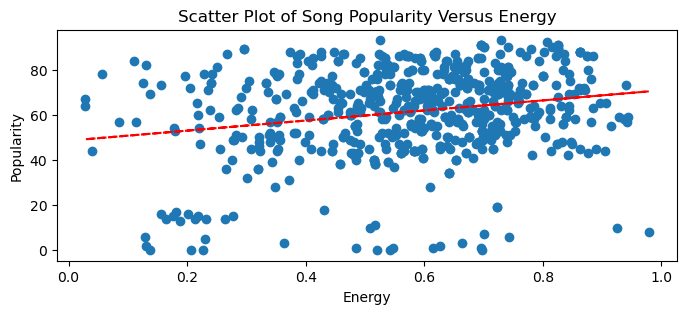

In [77]:
# Scatter plot of Song Popularity versus Energy
plt.scatter(df["energy"], df["popularity"])

# Add a trendline using linear regression
z = np.polyfit(df["energy"], df["popularity"], 1)
p = np.poly1d(z)
plt.plot(df["energy"], p(df["energy"]), "r--")

# Set the x and y axis labels
plt.xlabel("Energy")
plt.ylabel("Popularity")

# Set the title
plt.title("Scatter Plot of Song Popularity Versus Energy")

# Set the plot size
fig = plt.gcf()
fig.set_size_inches(8, 3)

# Display the plot
plt.show()

**BUSINESS INSIGHT : The scatter plot suggests that there is a positive relationship between energy and popularity, as indicated by the upward trendline. This means that songs with higher energy tend to be more popular than songs with lower energy. However, there is still a lot of variability in the data, which suggests that other factors besides energy are also important for predicting song popularity. The plot may be useful for music industry professionals who are interested in understanding which musical characteristics are most likely to lead to commercial success.**

**2. HISTOGRAM PLOT**

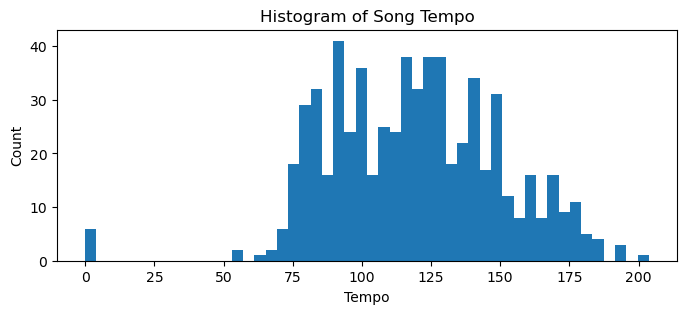

In [78]:
# Histogram of Song Tempo
plt.hist(df["tempo"], bins=50)

# Set the x and y axis labels
plt.xlabel("Tempo")
plt.ylabel("Count")

# Set the title
plt.title("Histogram of Song Tempo")

# Set the plot size
fig = plt.gcf()
fig.set_size_inches(8, 3)

# Display the plot
plt.show()

**BUSINESS INSIGHT:The histogram suggests that song tempos are generally distributed with a peak in the range of 115-125 BPM. This peak may represent a common tempo range for popular music genres, such as pop or rock. Additionally, the plot shows that there are some outliers at very low tempos, which may represent songs in less common genres or with unusual characteristics. The plot may be useful for music industry professionals who are interested in understanding trends in tempo preferences among music listeners.**

**3. BAR PLOT**

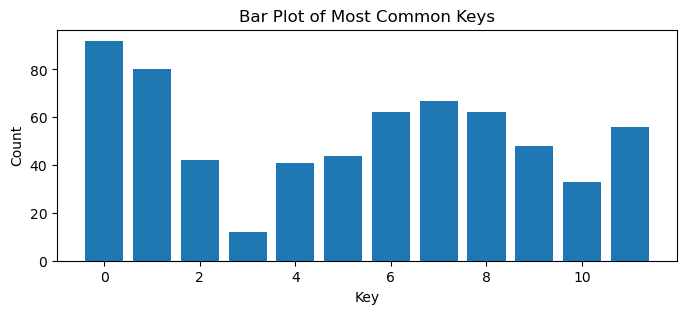

In [79]:
# Bar plot of most common keys
key_counts = df["key"].value_counts().sort_index()
plt.bar(key_counts.index, key_counts.values)

# Set the x and y axis labels
plt.xlabel("Key")
plt.ylabel("Count")

# Set the title
plt.title("Bar Plot of Most Common Keys")

# Set the plot size
fig = plt.gcf()
fig.set_size_inches(8, 3)

# Display the plot
plt.show()

**BUSINESS INSIGHT: The plot suggests that the most common keys used in songs are 0, 1, and 7. Additionally, the plot shows that some of the less common keys, such as 3 and 10, are also represented in the dataset. This information may be useful for music professionals who want to understand key preferences in different genres of music or time periods. Music performers might use this information to select keys that best suit their vocal or instrumental range, or to choose keys that are most likely to resonate with their audiences.**

**4. BOX PLOT**

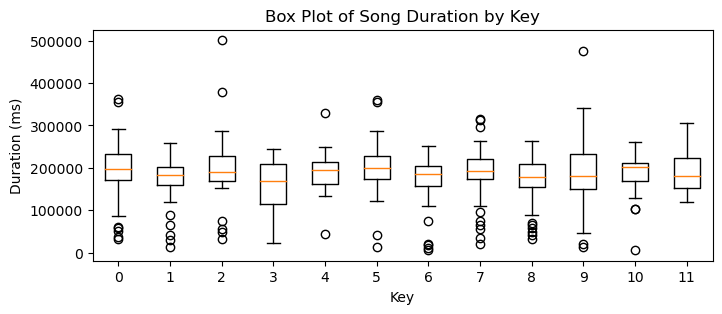

In [80]:
# Box plot of Song Duration by Key
keys = sorted(df["key"].unique())
data = [df[df["key"]==k]["duration_ms"] for k in keys]
plt.boxplot(data, labels=keys)

# Set the x and y axis labels
plt.xlabel("Key")
plt.ylabel("Duration (ms)")

# Set the title
plt.title("Box Plot of Song Duration by Key")

# Set the plot size
fig = plt.gcf()
fig.set_size_inches(8, 3)

# Display the plot
plt.show()

**BUSINESS INSIGHT: The plot suggests that there is some variation in song duration across different keys. For example, the songs in the key of 10 have a longer median duration than songs in other keys. Additionally, the plot shows that the duration of songs in the key of 9 has the highest range of durations, with some songs being relatively short and others being very long. This information may be useful for music professionals who want to understand how song duration varies across different keys.**

**5. HEATMAP**

In [83]:
# Heatmap of song features correlation

corr = df.corr()
fig = px.imshow(corr, color_continuous_scale="RdBu_r")
fig.update_layout(title="Song Features Correlation Matrix",width=1000, height=600)
fig.show()

In [150]:
# Compute the correlation matrix
corr = df.corr()

# Convert the correlation matrix to a DataFrame
corr_df = pd.DataFrame(corr, columns=df.columns, index=df.columns)

# Get the top 10 highly correlated variables
top_corr_vars = corr_df.unstack().sort_values(ascending=False).drop_duplicates()[:10].index.tolist()

# Filter the original DataFrame to keep only the top 10 variables
df_top_corr_vars = df.filter(items=top_corr_vars)

**6. PIE CHART**

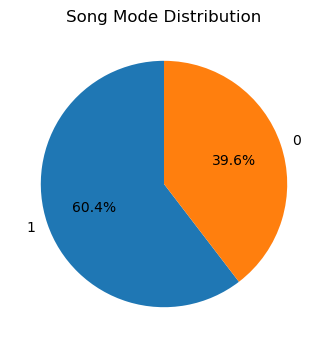

In [84]:
# Pie Chart of Song mode distribution
mode_counts = df["mode"].value_counts()
fig, ax = plt.subplots()
ax.pie(mode_counts.values, labels=mode_counts.index, autopct='%1.1f%%', startangle=90)
ax.set_title("Song Mode Distribution")

# Set the plot size
fig.set_size_inches(5, 4)

# Display the plot
plt.show()

**BUSINESS INSIGHT: The pie chart of Song Mode distribution shows the proportion of songs belonging to value of 0 and 1. In the given example, the chart indicates that about 62.6% of the songs belongs to value of 1, while the remaining 37.4% belongs to value of 0. This insight could be useful for music industry professionals who want to understand the preferences of listeners and create music accordingly.**

**7. LINE PLOT**

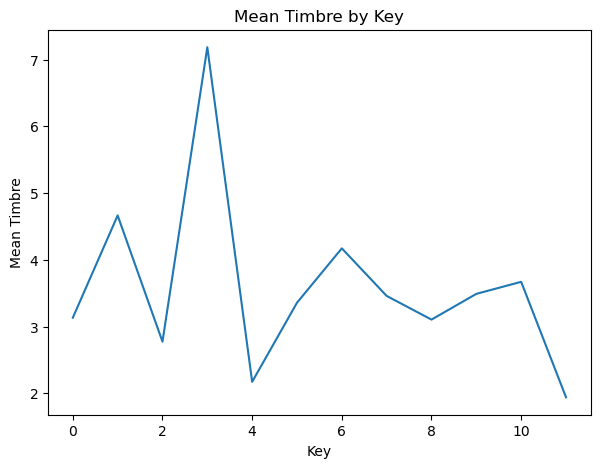

In [85]:
# Line plot of mean timbre by key
mean_timbre_by_key = df.groupby("key")["Mean.Timbre"].mean().sort_index()
fig, ax = plt.subplots()
ax.plot(mean_timbre_by_key.index, mean_timbre_by_key.values)
ax.set_xlabel("Key")
ax.set_ylabel("Mean Timbre")
ax.set_title("Mean Timbre by Key")

# Set the plot size
fig.set_size_inches(7, 5)

# Display the plot
plt.show()

**BUSINESS INSIGHT: The line plot of mean timbre by key shows the variation in the mean timbre value across different keys. Timbre refers to the quality of sound that distinguishes different types of musical instruments or voices. The plot shows that key 3 have higher mean timbre values than others. This information can be useful for music producers and composers in selecting the appropriate key for their music based on the desired sound quality.**

**8. WORD CLOUD**

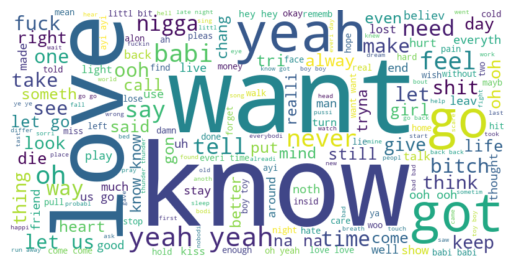

In [165]:
# Word cloud of song lyrics

all_lyrics = " ".join(df["cleaned_lyrics"].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_lyrics)

fig, ax = plt.subplots()
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.show()

**9. SCATTER PLOT**

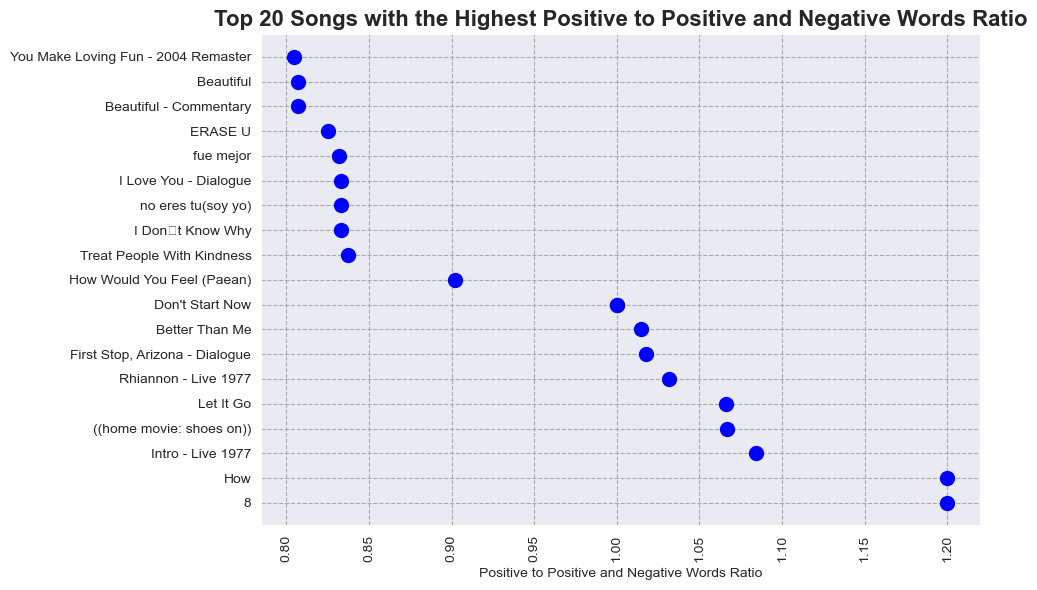

In [174]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt

# Define a function to get the sentiment ratio of each lyric
def get_pos_pos_ratio(lyric):
    blob = TextBlob(lyric)
    sentiment = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    if subjectivity == 0:
        return 0
    else:
        return sentiment / subjectivity

# Add a sentiment ratio column to the DataFrame
df["pos_pos_ratio"] = df["cleaned_lyrics"].apply(get_pos_pos_ratio)

# Select the top 20 songs with the highest positive to positive and negative words ratio
top_pos_pos_ratio_songs = df.sort_values(by="pos_pos_ratio", ascending=False)[:20]

# Create a scatter plot for the top 20 songs with the highest negative to positive and negative words ratio
plt.figure(figsize=(10, 6))
plt.scatter(x=top_pos_pos_ratio_songs["pos_pos_ratio"], y=top_pos_pos_ratio_songs["song_name"], color="blue", s=100)
plt.title("Top 20 Songs with the Highest Positive to Positive and Negative Words Ratio", fontsize=16, fontweight="bold")
plt.xlabel("Positive to Positive and Negative Words Ratio")
plt.ylabel("")
plt.xticks(rotation=90)
plt.grid(ls="--", color="darkgrey")
plt.tight_layout()
plt.show()

**BUSINESS INSIGHT: The above plots shows the top 20 most positive songs based on their sentiment ratio. The sentiment ratio is calculated by dividing the sentiment polarity of the lyrics by the sentiment subjectivity of the lyrics. A higher sentiment ratio indicates that the lyrics have a more positive sentiment compared to negative sentiment. The plot can be used to identify the most positive songs in a given dataset and to understand the sentiment of those songs. This information can be useful for businesses in the music industry to identify popular and well-received songs that can be used for various purposes, such as marketing campaigns, playlists, or events.**

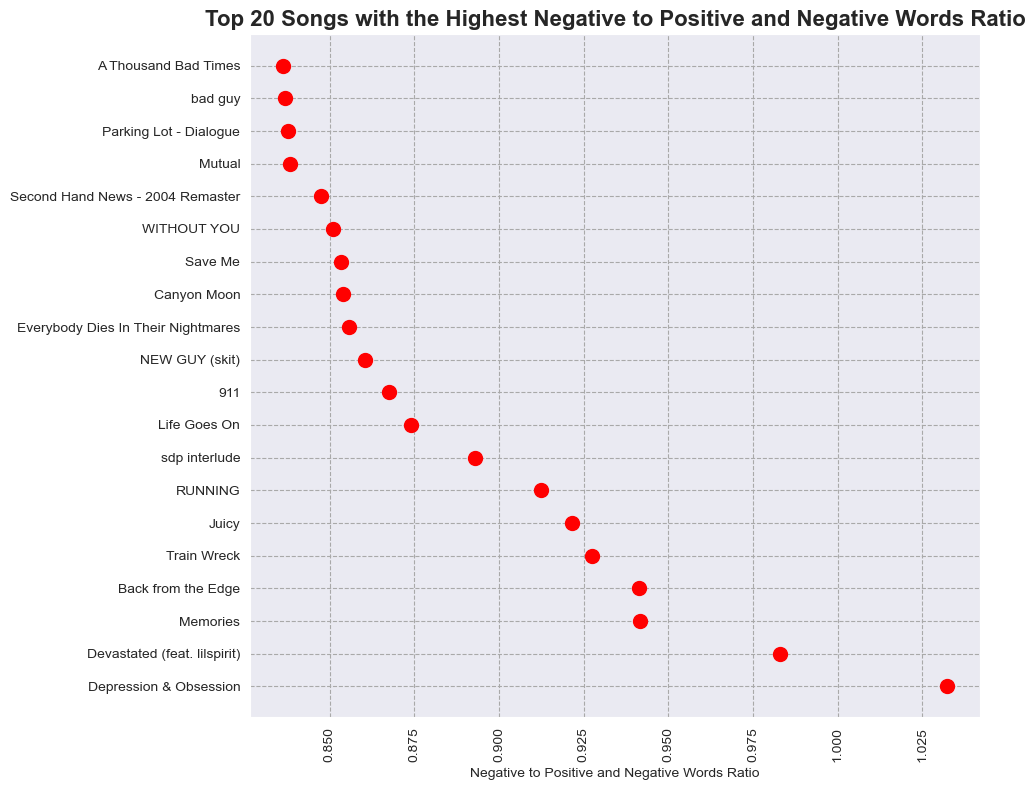

In [172]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt

# Define a function to get the negative to positive and negative words ratio of each lyric
def get_neg_pos_ratio(lyric):
    blob = TextBlob(lyric)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    if subjectivity == 0:
        return 0
    else:
        return (1 - polarity) / (1 + subjectivity)

# Add a negative to positive and negative words ratio column to the DataFrame
df["neg_pos_ratio"] = df["cleaned_lyrics"].apply(get_neg_pos_ratio)

# Select the top 20 songs with the highest negative to positive and negative words ratio
top_neg_pos_ratio_songs = df.sort_values(by="neg_pos_ratio", ascending=False)[:20]

# Create a scatter plot for the top 20 songs with the highest negative to positive and negative words ratio
plt.figure(figsize=(10, 8))
plt.scatter(x=top_neg_pos_ratio_songs["neg_pos_ratio"], y=top_neg_pos_ratio_songs["song_name"], color="red", s=100)
plt.title("Top 20 Songs with the Highest Negative to Positive and Negative Words Ratio", fontsize=16, fontweight="bold")
plt.xlabel("Negative to Positive and Negative Words Ratio")
plt.ylabel("")
plt.xticks(rotation=90)
plt.grid(ls="--", color="darkgrey")
plt.tight_layout()
plt.show()

**BUSINESS INSIGHT: The above plot shows the top 20 most negative songs based on their negative-to-positive sentiment ratio. The sentiment ratio is calculated by taking the absolute value of the negative sentiment polarity of the lyrics and dividing it by the positive sentiment polarity of the lyrics. A higher sentiment ratio indicates that the lyrics have a more negative sentiment compared to positive sentiment. The plot can be used to identify the most negative songs in a given dataset and to understand the sentiment of those songs. This information can be useful for businesses in the music industry to identify songs that may not be well-received by consumers and to avoid using them for various purposes, such as marketing campaigns, playlists, or events.**

### Song recommendation

In [ ]:
#Reading the data and subsetting those values without lyrics
data=pd.read_csv("..\Data\lyrics_preprocessed.csv")\
.drop('Unnamed: 0',axis=1)\
.dropna(subset='cleaned_lyrics')

#We will keep only the id and the lyrics
df=data[['id','cleaned_lyrics']]

In [ ]:
#let's create a string that contains the lyric.
new_lyric="I used to rule the world Seas would rise when I gave the word Now in the morning I sweep alone Sweep the streets I used to own I used to roll the dice Feel the fear in my enemy's eyes Listen as the crowd would sing: Now the old king is dead! Long live the king! One minute I held the key Next the walls were closed on me And I discovered that my castles stand Upon pillars of salt and pillars of sand I hear Jerusalem bells a ringing Roman Cavalry choirs are singing Be my mirror my sword and shield My missionaries in a foreign field For some reason I can't explain Once you go there was never, never an honest word That was when I ruled the world (Ohhh) It was the wicked and wild wind Blew down the doors to let me in Shattered windows and the sound of drums People couldn't believe what I'd become Revolutionaries wait For my head on a silver plate Just a puppet on a lonely string Oh who would ever want to be king? I hear Jerusalem bells a ringing Roman Cavalry choirs are singing Be my mirror my sword and shield My missionaries in a foreign field For some reason I can't explain I know Saint Peter will call my name Never an honest word But that was when I ruled the world (Ohhhhh Ohhh Ohhh) I hear Jerusalem bells a ringing Roman Cavalry choirs are singing Be my mirror my sword and shield My missionaries in a foreign field For some reason I can't explain I know Saint Peter will call my name Never an honest word But that was when I ruled the world"

In [ ]:
#We will pass our initial dataframe and the new lyrics into our transformation function.
Transformed=transformation_weighted_avg_emb(dataframe=df, lyric=new_lyric)

##### Outputs

**Tokens**

In [ ]:
Transformed['tokens'].head()

**Matrix**

In [ ]:
Transformed['matrix'].head()

In [ ]:
recommendation(matrix=Transformed['matrix'],target_id='03mMSLEJCPoGJwQhHpN5y0', N=5)

### Appendix 1: Look for the ideal topics

*Reference:*  https://stackoverflow.com/questions/32313062/what-is-the-best-way-to-obtain-the-optimal-number-of-topics-for-a-lda-model-usin

In [ ]:
corpus=df['tokenized_lyrics']
dirichlet_dict = corpora.Dictionary(corpus)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in corpus]

# Considering 1-15 topics, as the last is cut off
num_topics = list(range(16)[1:])
num_keywords = 15

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel(corpus=bow_corpus,
                             id2word=dirichlet_dict,
                             num_topics=i,
                             update_every=1,
                             chunksize=len(bow_corpus),
                             passes=20,
                             alpha='auto',
                             random_state=42)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [ ]:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [ ]:
coherences = [CoherenceModel(model=LDA_models[i], texts=corpus, dictionary=dirichlet_dict, coherence='c_v').get_coherence()\
              for i in num_topics[:-1]]

In [ ]:
coherences

In [ ]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show() 

Number of optimal topics 13, where we minimize the average topic overlap and topic coherence

In [ ]:
### 2. See the topic distribution for a specific tweet

lda_model.get_document_topics(corpus[0])

In [ ]:
# Scatter plot of danceability versus valence colored by song popularity

fig = px.scatter(df, x="danceability", y="valence", color="popularity")
fig.show()